# cml1 - Immobilienrechner
# Modellierung

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
import xgboost as xgb

## Cleaned Dataset

In [3]:
df = pd.read_csv('../data/immo_data_clean.csv', low_memory=False)

In [4]:
# Check for missing values
missing_data = df.isnull().sum().sort_values(ascending=False)
missing_percentage = (df.isnull().sum() / df.shape[0]).sort_values(ascending=False) * 100

# Combine the results into a single DataFrame
missing_df = pd.concat([missing_data, missing_percentage], axis=1, keys=['Total Missing', 'Percentage (%)'])

# Display columns with missing data
missing_df[missing_df['Total Missing'] > 0]

,Total Missing,Percentage (%)
Space extracted,21068,98.145905
Year built:,14533,67.702413
Plot_area_merged,13761,64.106028
Living_area_unified,1301,6.060747
rooms,697,3.246995


In [5]:
# Separate numerical and categorical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# df without categorical columns
df_num = df.drop(categorical_cols, axis=1)

## Feature Selection
### Correlation

In this section we will identify highly correlated features. This is an important step in feature seleciton. The logic behind this is that if two (or more) variables are highly correlated, they contain redundant information, which can be problematic for some machine learning algorithms, especially linear regression.

In [7]:
# Compute the correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Find features that have a correlation greater than 0.8 with another feature
highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)

highly_correlated_features = list(highly_correlated_features)
highly_correlated_features

['ForestDensityM',
 'gde_pop_per_km2',
 'gde_workers_total',
 'gde_population',
 'PopulationDensityM',
 'RiversAndLakesM',
 'gde_private_apartments',
 'NoisePollutionRoadS',
 'PopulationDensityS',
 'NoisePollutionRoadM',
 'WorkplaceDensityM',
 'WorkplaceDensityS',
 'ForestDensityS',
 'NoisePollutionRailwayM']

We've identified several features that have a correlation greater than 0.8 with at least one other feature.

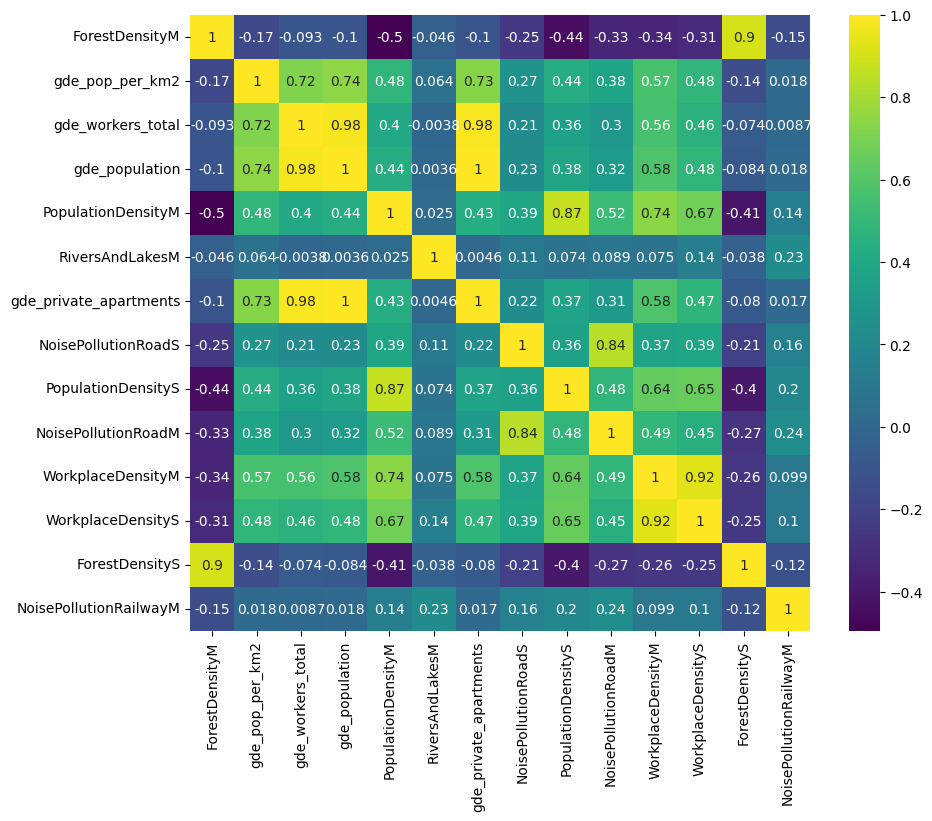

In [8]:
correlation_matrix = df_num[highly_correlated_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis')
plt.show()

Here are the pairs of correlated features:

- ForestDensityM & ForestDensityS

- gde_workers_total & gde_population
- gde_workers_total & gde_private_apartments

- PopulationDensityM & PopulationDensityS

- NoisePollutionRoadS & NoisePollutionRoadM

- WorkplaceDensityM & WorkplaceDensityS


### Feature Importance
#### XGBoost & Random Forest
To determine the importance of each feature we will use the xgboost and random forest libraries and then compare the results.

In [59]:
# Split the data into features (X) and target (y)
X = df_num.drop("price_cleaned", axis=1)
y = df_num["price_cleaned"]

# Instantiate the XGBRegressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10, seed=123)

# fit the model
xg_reg.fit(X, y);

In [60]:
# Split the data into features (X) and target (y)
X = df_num.drop("price_cleaned", axis=1)
y = df_num["price_cleaned"]

# Handle missing values by imputation (using median strategy for simplicity)
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Extract feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for feature importances
df_random_forest_features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

df_random_forest_features.head()

,Feature,Importance
3,Living_area_unified,0.481711
4,Plot_area_merged,0.084692
23,gde_tax,0.062199
0,Zip,0.051708
19,gde_pop_per_km2,0.031209


The table above presents the features ranked by their importance, as determined by the Random Forest model. The most important features have the highest importance scores.

- Living_area_unified is the most important feature, explaining a significant portion of the variability in price_cleaned.
- Plot_area_merged, gde_tax and Zip are the next three important features.

Some features have relatively low importance scores. Depending on the context and the model's purpose, you might consider excluding these from your model to simplify it.

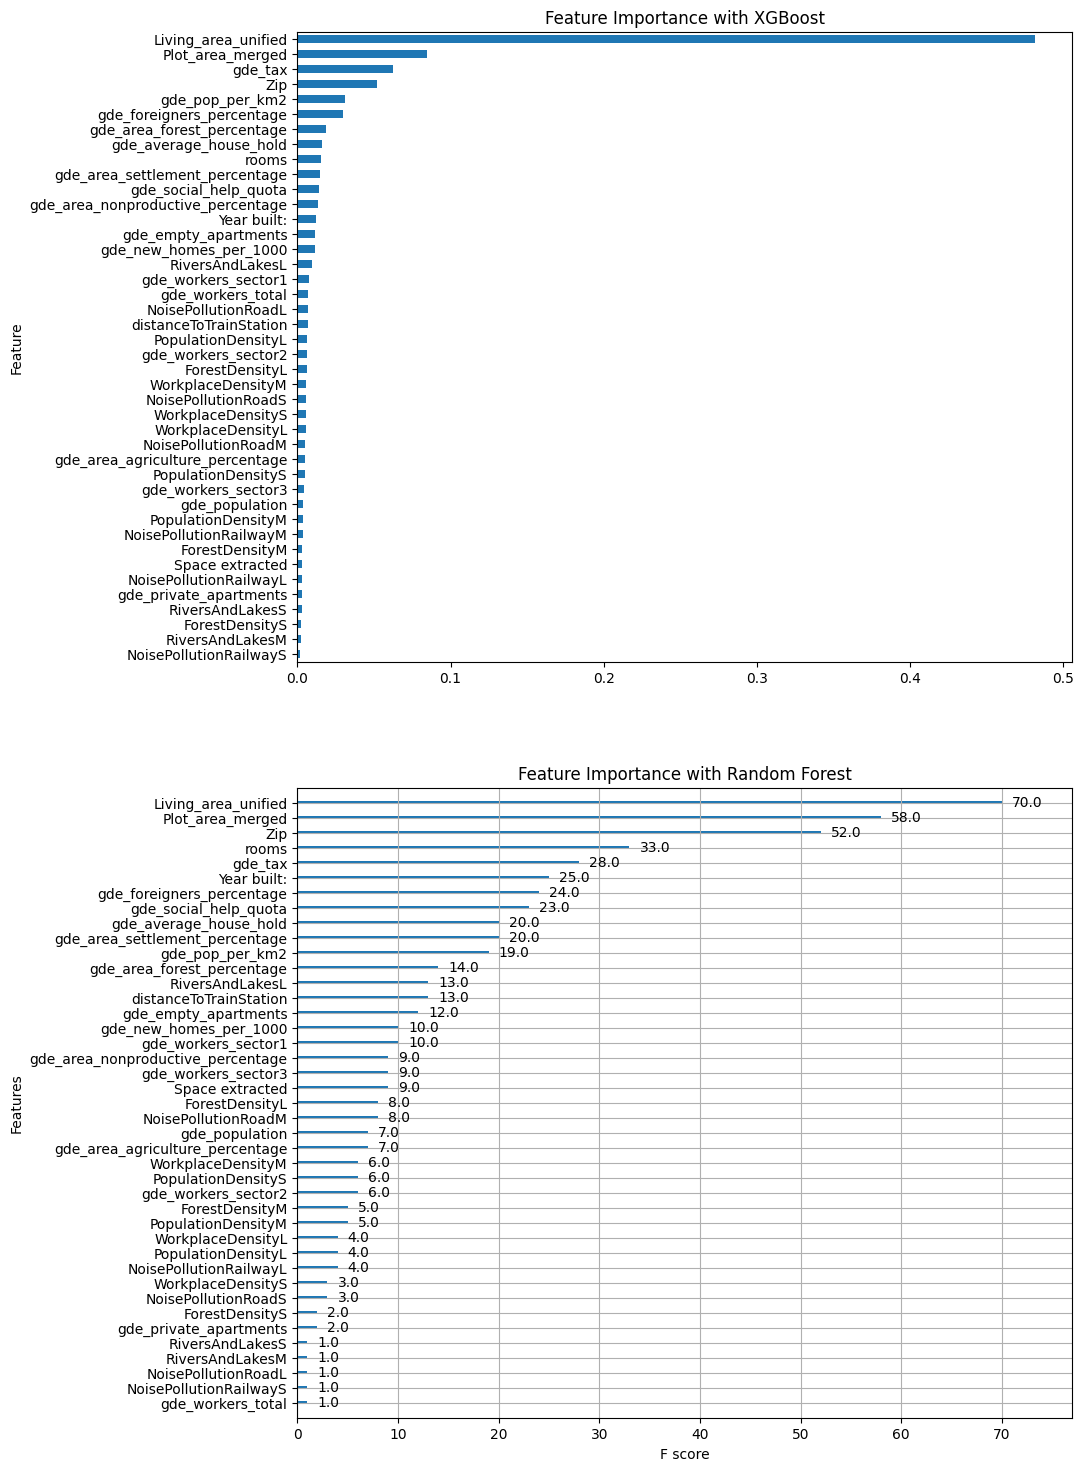

In [62]:
fig, axes = plt.subplots(2, 1, figsize=(10, 18))

xgb.plot_importance(xg_reg, ax=axes[1])
axes[0].set_title('Feature Importance with XGBoost')

df_random_forest_features.sort_values(by='Importance', ascending=True).plot.barh(x='Feature', y='Importance', ax=axes[0])
axes[1].set_title('Feature Importance with Random Forest')

# no legend
axes[0].get_legend().remove()

plt.show()

Common Important Features:
- Living_area_unified
- Plot_area_merged
- gde_tax
- Zip
- gde_foreigners_percentage
- gde_average_house_hold
- gde_pop_per_km2
- rooms
- gde_social_help_quota
- gde_area_settlement_percentage

Divergent Features:
- none

It's important to note that the common features above do not appear in the high correlation list calculated earlier.

In [53]:
columns_to_keep = [
    'Living_area_unified', 'Plot_area_merged', 'gde_tax', 'Zip', 'gde_foreigners_percentage',
    'gde_average_house_hold', 'gde_pop_per_km2', 'rooms', 'gde_social_help_quota',
    'gde_area_settlement_percentage'
]

df_features = df[columns_to_keep]

## Model Selection

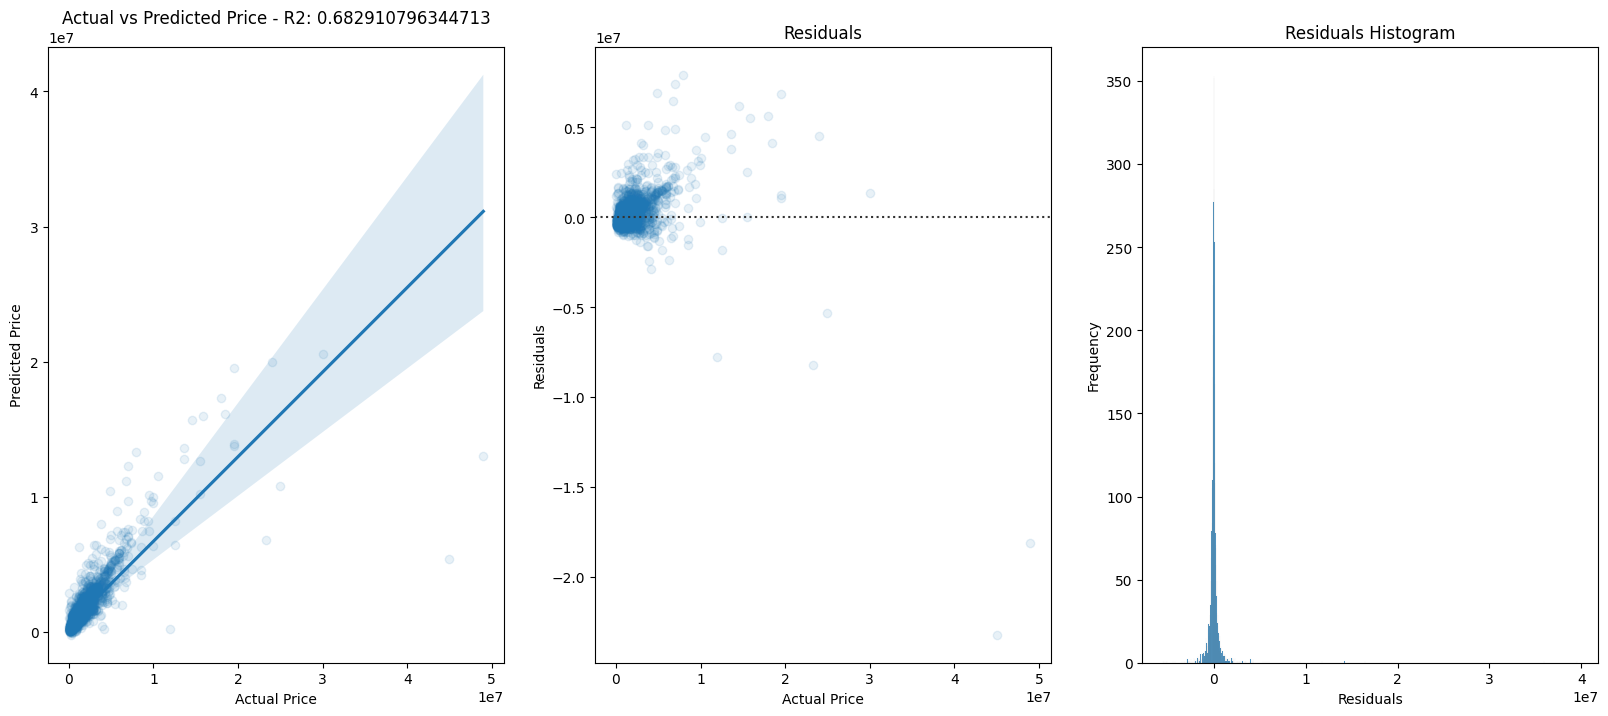

In [70]:
# predict the price with xgboost
X = df_features
y = df["price_cleaned"]

model = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)

fig, ax = plt.subplots(1, 3, figsize=(20, 8))

# actual vs predicted plot
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha': 0.1}, ax=ax[0])
ax[0].set_title('Actual vs Predicted Price - R2: {}'.format(r2))
ax[0].set_xlabel('Actual Price')
ax[0].set_ylabel('Predicted Price')

# residuals plot
sns.residplot(x=y_test, y=y_pred, scatter_kws={'alpha': 0.1}, ax=ax[1])
ax[1].set_title('Residuals')
ax[1].set_xlabel('Actual Price')
ax[1].set_ylabel('Residuals')

# histogram plot
sns.histplot((y_test - y_pred), ax=ax[2])
ax[2].set_title('Residuals Histogram')
ax[2].set_xlabel('Residuals')
ax[2].set_ylabel('Frequency')

plt.show()

### Linear Regression

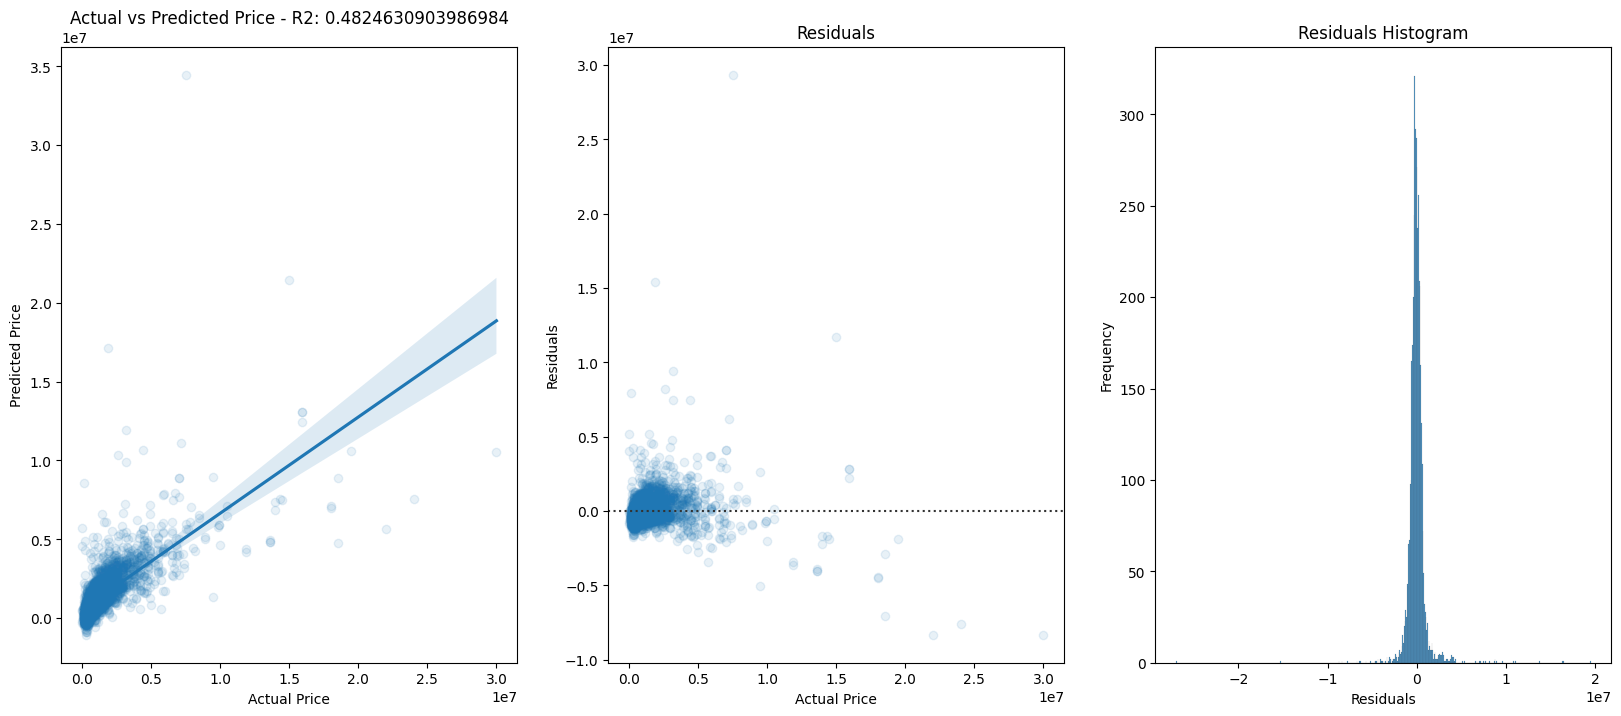

In [39]:
# create ml model based to predict price_cleaned, data = df_numeric
X = df.drop('price_cleaned', axis=1)
y = df['price_cleaned']

imputer = SimpleImputer(strategy='mean') # can also use 'median' or 'most_frequent' for mode
X = imputer.fit_transform(X)

# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# create linear regression model
lr = LinearRegression()

# fit model to training data
lr.fit(X_train, y_train)

# predict on test data
y_pred = lr.predict(X_test)

# calculate r2 score
r2 = r2_score(y_test, y_pred)

fig, ax = plt.subplots(1, 3, figsize=(20, 8))

# actual vs predicted plot
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha': 0.1}, ax=ax[0])
ax[0].set_title('Actual vs Predicted Price - R2: {}'.format(r2))
ax[0].set_xlabel('Actual Price')
ax[0].set_ylabel('Predicted Price')

# residuals plot
sns.residplot(x=y_test, y=y_pred, scatter_kws={'alpha': 0.1}, ax=ax[1])
ax[1].set_title('Residuals')
ax[1].set_xlabel('Actual Price')
ax[1].set_ylabel('Residuals')

# histogram plot
sns.histplot((y_test - y_pred), ax=ax[2])
ax[2].set_title('Residuals Histogram')
ax[2].set_xlabel('Residuals')
ax[2].set_ylabel('Frequency')

plt.show()

### Ridge Regression

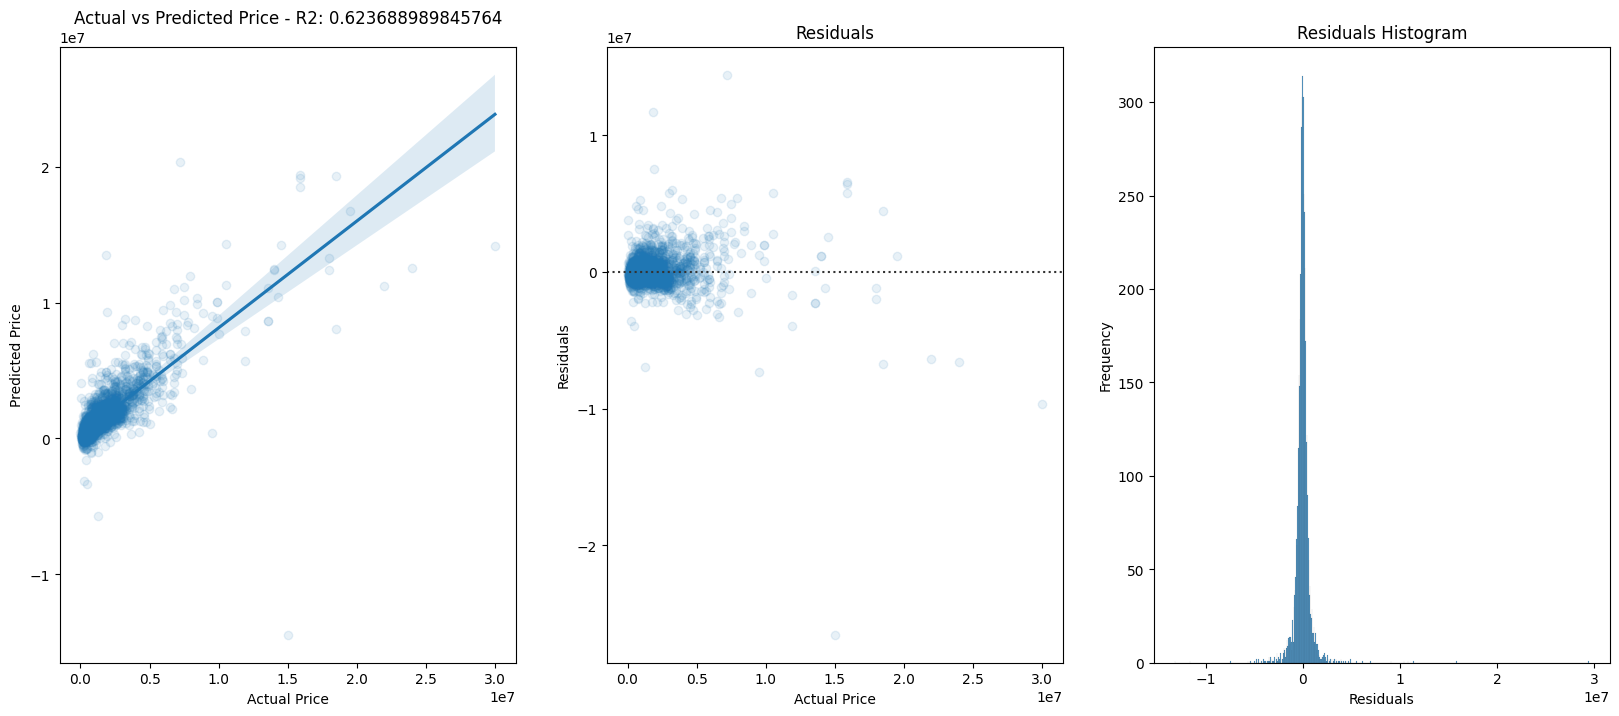

In [40]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge

# Feature scaling and polynomial features
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Ridge regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_poly, y_train)
y_pred_ridge = ridge.predict(X_test_poly)

# r2 score for ridge regression
r2_ridge = r2_score(y_test, y_pred_ridge)

# residuals plot and histogram plot side by side
fig, ax = plt.subplots(1, 3, figsize=(20, 8))

# actual vs predicted plot
sns.regplot(x=y_test, y=y_pred_ridge, scatter_kws={'alpha': 0.1}, ax=ax[0])
ax[0].set_title('Actual vs Predicted Price - R2: {}'.format(r2_ridge))
ax[0].set_xlabel('Actual Price')
ax[0].set_ylabel('Predicted Price')

# residuals plot
sns.residplot(x=y_test, y=y_pred_ridge, scatter_kws={'alpha': 0.1}, ax=ax[1])
ax[1].set_title('Residuals')
ax[1].set_xlabel('Actual Price')
ax[1].set_ylabel('Residuals')

# histogram plot
sns.histplot((y_test - y_pred_ridge), ax=ax[2])
ax[2].set_title('Residuals Histogram')
ax[2].set_xlabel('Residuals')
ax[2].set_ylabel('Frequency')

plt.show()

### Lasso Regression

In [19]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Initialize and train Lasso regression model
alpha_value = 0.1  # Regularization strength; can be tuned
lasso = Lasso(alpha=alpha_value, max_iter=10000)
lasso.fit(X_scaled, y)

# Predict on the training set
y_pred = lasso.predict(X_scaled)

# Calculate the RMSE
rmse = mean_squared_error(y, y_pred, squared=False)

# Extract feature coefficients
coefficients = lasso.coef_
lasso_coeff_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

rmse, lasso_coeff_df

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.691e+15, tolerance: 6.237e+12
  model = cd_fast.enet_coordinate_descent(


(1230539.9608953975,
                               Feature    Coefficient
 3                 Living_area_unified  865067.822767
 21             gde_private_apartments  636044.180047
 33                    RiversAndLakesL  251579.841976
 5                               rooms  235064.588753
 17          gde_foreigners_percentage  210842.265109
 14     gde_area_settlement_percentage  171159.231078
 30                 PopulationDensityL  113756.341284
 27                NoisePollutionRoadL   98196.690828
 2                     Space extracted   91883.210648
 29                NoisePollutionRoadS   89616.337362
 15             gde_average_house_hold   84699.073874
 32                 PopulationDensityS   84425.663367
 1                         Year built:   78332.788979
 4                    Plot_area_merged   77908.764827
 20                     gde_population   61467.127776
 25             NoisePollutionRailwayM   59123.970871
 37                  WorkplaceDensityM   47816.484450
 38    

### Random Forest

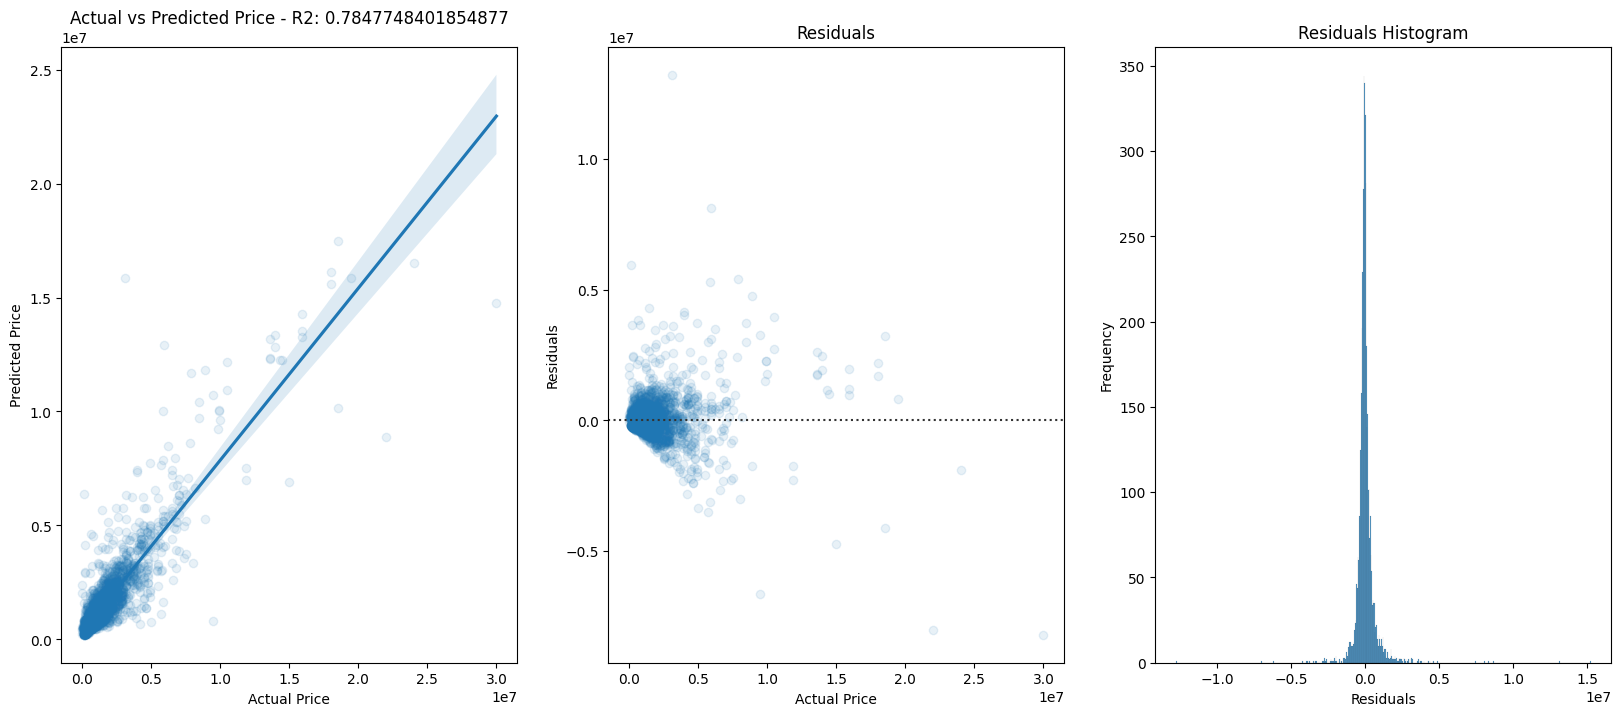

In [41]:
from sklearn.ensemble import RandomForestRegressor

# Create random forest regressor
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# Fit model to training data
rf.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf.predict(X_test)

# Calculate r2 score
r2_rf = r2_score(y_test, y_pred_rf)

# residuals plot and histogram plot side by side
fig, ax = plt.subplots(1, 3, figsize=(20, 8))

# actual vs predicted plot
sns.regplot(x=y_test, y=y_pred_rf, scatter_kws={'alpha': 0.1}, ax=ax[0])
ax[0].set_title('Actual vs Predicted Price - R2: {}'.format(r2_rf))
ax[0].set_xlabel('Actual Price')
ax[0].set_ylabel('Predicted Price')

# residuals plot
sns.residplot(x=y_test, y=y_pred_rf, scatter_kws={'alpha': 0.1}, ax=ax[1])
ax[1].set_title('Residuals')
ax[1].set_xlabel('Actual Price')
ax[1].set_ylabel('Residuals')

# histogram plot
sns.histplot((y_test - y_pred_rf), ax=ax[2])
ax[2].set_title('Residuals Histogram')
ax[2].set_xlabel('Residuals')
ax[2].set_ylabel('Frequency')

plt.show()

# MLR to do:

- drop columns -> finish EDA
- regularisierung
- variablen transformieren
- random forest
- hist gradient boosting regresser